# E-Discovery with Neural Network
## BigData Processing
### Hadoop / PySpark 

Dataset zip file - https://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz
Dataset License - https://www.cs.cmu.edu/~enron/

Commands to be include in the Linux Terminal in order to start Hadoop and PySpark

$start-dfs.sh

$start-yarn.sh

$pyspark


### PySpark reading a file form a CSV
Firstly, necessary modules are imported to enable Spark operations, handle string data, and work with regular expressions. To ensure a smooth experience, warnings from the Python code will be suppressed, meaning they won't interrupt or clutter the output.

Following the preparation, a Spark session is initiated. Think of this session as the starting point for all Spark operations. It's named "EmailDataPrep" to reflect its purpose: preparing email data for analysis or further processing.

Finally, it leads to reading the data. The CSV file located in a distributed file system (HDFS) will be read into a DataFrame. A DataFrame is a table of data with rows and columns, where the data can be manipulated and analyzed. The reading process is designed to recognize the first row as column names (header=True) and automatically deduce the type of data in each column (inferSchema=True). This step concludes the initial data loading, setting the stage for subsequent data manipulation and analysis tasks.

In [1]:
# Initiating required modules
from pyspark.sql import SparkSession  # Essential for Spark operations
from pyspark.sql.functions import udf  # User Defined Functions
from pyspark.sql.types import StringType  # Data type for string operations
import re  # Regular expressions library

# Handling warnings
import warnings  # Importing warnings library
warnings.filterwarnings("ignore")  # Suppress all warnings


In [2]:
# Setting up the Spark Session
spark = SparkSession.builder.appName("EmailDataPrep").getOrCreate()

# Reading the data
df = spark.read.csv("hdfs:///user1/emails.csv", header=True, inferSchema=True)


24/03/31 23:08:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Exploratory Data Analysis (EDA) / Data Inspection
This section focuses on Exploratory Data Analysis (EDA) and data inspection using PySpark, a tool for handling big data. The aim is to understand the data better by performing initial checks and summaries. 

Through these steps, the data is initially assessed to guide further detailed analysis and decision-making for cleaning, transforming, and analyzing the data effectively.

In [3]:
# Preview the initial rows of the DataFrame
df.show(n=10)


+--------------------+--------------------+
|                file|             message|
+--------------------+--------------------+
|allen-p/_sent_mai...|Message-ID: <1878...|
|           Date: Mon| 14 May 2001 16:3...|
|From: phillip.all...|                null|
|To: tim.belden@en...|                null|
|           Subject: |                null|
|   Mime-Version: 1.0|                null|
|Content-Type: tex...|                null|
|Content-Transfer-...|                null|
|X-From: Phillip K...|                null|
|X-To: Tim Belden ...|                null|
+--------------------+--------------------+
only showing top 10 rows



In [4]:
# Output the structure and data types of the DataFrame
df.printSchema()


root
 |-- file: string (nullable = true)
 |-- message: string (nullable = true)



In [5]:
# Obtain and display descriptive statistics for columns with numerical data
df.describe().show()


+-------+--------------------+--------+
|summary|                file| message|
+-------+--------------------+--------+
|  count|             8299853| 2508249|
|   mean|                 NaN|Infinity|
| stddev|                 NaN|     NaN|
|    min|                  \t|      \t|
|    max|~~~~~~~~~~~~~~~~~...|       ||
+-------+--------------------+--------+



### Data Cleaning / Text Preprocessing
This section is about cleaning the data and preparing text for analysis. Data often comes with issues like missing information, inconsistencies, and unnecessary details that can affect analysis. Here's how the process unfolds:

Through these steps, the dataset is refined and prepared, setting a solid foundation for subsequent analysis or machine learning tasks.

In [6]:
# Addressing Missing Information
# Replace any missing values in the dataset with an empty string.
df = df.fillna('')

# Defining a Function for Text Cleanup
def clean_text(text):
    # Return an empty string if the input text is missing.
    if text is None:
        return ''
    # Change all characters in the text to lowercase for uniformity.
    text = text.lower()
    # Eliminate lines that resemble email headers or unneeded metadata.
    text = re.sub(r'^[a-z]+:.*$', '', text)  # Finds and removes lines starting with certain patterns.
    text = re.sub(r'\s+', ' ', text)  # Collapses multiple spaces into a single space.
    # Remove characters that are not letters, numbers, or spaces.
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Trim leading or trailing spaces from the text.
    return text.strip()

# Making the Text Cleanup Function Available
clean_text_udf = udf(clean_text, StringType())

# Cleaning Text in the 'message' Column of the Dataset
df = df.withColumn('message', clean_text_udf(df['message']))

# Displaying the Processed Data for Review
df.show(truncate=False)


+----------------------------------------------+-------------------------------------------------+
|file                                          |message                                          |
+----------------------------------------------+-------------------------------------------------+
|allen-p/_sent_mail/1.                         |messageid 187829811075855378110javamailevansthyme|
|Date: Mon                                     |14 may 2001 163900 0700 pdt                      |
|From: phillip.allen@enron.com                 |                                                 |
|To: tim.belden@enron.com                      |                                                 |
|Subject:                                      |                                                 |
|Mime-Version: 1.0                             |                                                 |
|Content-Type: text/plain; charset=us-ascii    |                                                 |
|Content-T

### Feature Engineering and Vectorization
This section focuses on Feature Engineering and Vectorization, essential steps in preparing text data for machine learning models. The goal is to transform the text from the 'message' column of a DataFrame into a numerical format that a machine learning model can understand.

By converting text into numerical features through these steps, the data is now ready to be used in machine learning models for tasks like classification, clustering, or sentiment analysis. This process of feature engineering and vectorization is crucial for extracting meaningful information from text data.

In [7]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline

def add_text_features(dataframe):
    """
    Enhances a DataFrame by analyzing text in the 'message' column and adding a 'features' column.
    This 'features' column represents text as numerical data useful for machine learning.
    
    Parameter:
    - dataframe: A DataFrame that includes a 'message' column with text.
    
    Output:
    - A DataFrame that now includes a 'features' column with text analyzed into TF-IDF vectors.
    """
    # First, break text into individual words.
    tokenizer = Tokenizer(inputCol="message", outputCol="words")
    
    # Second, filter out common, less meaningful words (like 'the', 'a').
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    
    # Third, count how frequently each word appears and represent this as numerical data.
    hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=20)
    
    # Fourth, assess the importance of a word based on how frequently it appears across all messages.
    idf = IDF(inputCol="raw_features", outputCol="features")
    
    # Chain these steps into a process to be applied.
    pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])
    
    # Execute the process on the provided data.
    model = pipeline.fit(dataframe)
    
    # Apply the transformations to the DataFrame.
    result = model.transform(dataframe)
    
    # The modified DataFrame is returned, now with a 'features' column.
    return result

# Example of applying this function to a DataFrame 'df' that contains a 'message' column.
enhanced_df = add_text_features(df)

# Display the original messages and their corresponding numerical representations.
enhanced_df.select('message', 'features').show(truncate=False)


+-------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|message                                          |features                                                                                                         |
+-------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|messageid 187829811075855378110javamailevansthyme|(20,[12,14],[0.2628853782003786,3.435649098139253])                                                              |
|14 may 2001 163900 0700 pdt                      |(20,[0,1,5,12],[6.620332160461084,6.1845443249149366,3.2725815853775964,0.2628853782003786])                     |
|                                                 |(20,[12],[0.2628853782003786])                                                                                   |
|   

### Design and Training - ANN Model
This section is dedicated to designing and training an Artificial Neural Network (ANN) model for binary classification tasks. The process involves using Keras, a high-level neural networks API, which runs on top of TensorFlow, a powerful open-source software library for machine learning.

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

def build_neural_network(input_features):
    """
    Prepares a neural network model with a basic configuration.
    """
    model = Sequential([
        Dense(64, input_dim=input_features, activation='relu'),  # Layer with 64 neurons
        Dropout(0.5),  # Helps reduce overfitting
        Dense(32, activation='relu'),  # Another layer for deeper understanding
        Dense(1, activation='sigmoid')  # Final layer for binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(features, labels, input_feature_count, epochs=100, batch_size=32, validation_split=0.2):
    """
    Trains the neural network and evaluates it on a validation set.
    """
    # Splitting the dataset for training and validation
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=validation_split, random_state=42)
    
    # Getting the model ready
    model = build_neural_network(input_feature_count)
    
    # Training starts
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), verbose=1)
    
    print("Training Completed.")
    
    # Saving the model for later use
    model.save("model_saved.h5")
    print("Model saved as model_saved.h5.")
    
    return model, history

# Sample data for testing
demo_features = np.random.rand(1000, 20)  # Random features for 1000 samples
demo_labels = np.random.randint(2, size=(1000, ))  # Random binary labels

# Training the model with the demo data
input_features = 20
model, history = train_and_evaluate_model(demo_features, demo_labels, input_features)



2024-03-31 23:10:09.365285: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-31 23:10:09.572463: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 23:10:09.572543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 23:10:09.609151: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-31 23:10:09.684576: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-31 23:10:09.685637: I tensorflow/core/platform/cpu_feature_guard.cc:1

Epoch 1/100
25/25 [==============================] - 1s 9ms/step - loss: 0.7023 - accuracy: 0.5025 - val_loss: 0.6885 - val_accuracy: 0.5200
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.7051 - accuracy: 0.4787 - val_loss: 0.6960 - val_accuracy: 0.4800
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7007 - accuracy: 0.4975 - val_loss: 0.6872 - val_accuracy: 0.5250
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5250 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.5238 - val_loss: 0.6911 - val_accuracy: 0.5050
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5437 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5550 - val_loss: 0.6966 - val_accuracy: 0.4850
Epoch 8/100
2

Epoch 59/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6117 - accuracy: 0.6488 - val_loss: 0.6857 - val_accuracy: 0.5650
Epoch 60/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6049 - accuracy: 0.6650 - val_loss: 0.6918 - val_accuracy: 0.5500
Epoch 61/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6117 - accuracy: 0.6363 - val_loss: 0.6762 - val_accuracy: 0.5700
Epoch 62/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6084 - accuracy: 0.6575 - val_loss: 0.6850 - val_accuracy: 0.5650
Epoch 63/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6338 - val_loss: 0.6886 - val_accuracy: 0.5750
Epoch 64/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6037 - accuracy: 0.6612 - val_loss: 0.6926 - val_accuracy: 0.5300
Epoch 65/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6016 - accuracy: 0.6737 - val_loss: 0.7018 - val_accuracy: 0.5500
Epoch 

In [9]:
from keras.models import load_model
import numpy as np

def get_fraud_chance(model_file, data):
    """
    This function takes a path to a trained machine learning model and an array of data,
    and it returns the model's estimates of the likelihood that each data point is fraudulent.
    
    Arguments:
    - model_file: The location of the trained model on the disk.
    - data: Array of data points that the model will evaluate. This array should be formatted just like the data used to train the model.
    
    Outcome:
    - An array with each data point's estimated fraud likelihood according to the model.
    """
    # Opening the model from the given file
    trained_model = load_model(model_file)
    
    # Making predictions with the model on the provided data
    fraud_chances = trained_model.predict(data)
    
    return fraud_chances

# Example: Predicting with a hypothetical model
# Setting up variables for demonstration. The real values depend on your specific model and data.
sample_count = 100  # Suppose you have 100 pieces of data
expected_shape = (20,)  # Suppose each piece of data should have 20 features

# Creating random data for the demonstration. In real use, you'd have actual data here.
data_samples = np.random.rand(sample_count, *expected_shape)

# Calling the function with the model's file path and the sample data
predicted_fraud_chances = get_fraud_chance('model_saved.h5', data_samples)

# Showing the model's fraud likelihood estimates for the sample data
print(predicted_fraud_chances)


4/4 [==============================] - 0s 2ms/step
[[0.55006844]
 [0.4313543 ]
 [0.36389148]
 [0.7733718 ]
 [0.6987809 ]
 [0.72788906]
 [0.5995639 ]
 [0.32532203]
 [0.2506975 ]
 [0.3685592 ]
 [0.7629408 ]
 [0.6236574 ]
 [0.15809405]
 [0.68128616]
 [0.18935156]
 [0.3305386 ]
 [0.88193434]
 [0.39460814]
 [0.4665374 ]
 [0.10511736]
 [0.76529336]
 [0.5602202 ]
 [0.7933351 ]
 [0.69063175]
 [0.8849559 ]
 [0.6765688 ]
 [0.24352828]
 [0.2410471 ]
 [0.6098922 ]
 [0.44240868]
 [0.5038173 ]
 [0.83673954]
 [0.71811485]
 [0.43862197]
 [0.5592406 ]
 [0.50652057]
 [0.57524836]
 [0.74198556]
 [0.62918055]
 [0.49341902]
 [0.6249169 ]
 [0.22921258]
 [0.401164  ]
 [0.4849874 ]
 [0.36502358]
 [0.7546762 ]
 [0.10664484]
 [0.60921836]
 [0.79718393]
 [0.42477942]
 [0.3368111 ]
 [0.7047334 ]
 [0.548316  ]
 [0.9549824 ]
 [0.89418906]
 [0.7625622 ]
 [0.5427132 ]
 [0.728859  ]
 [0.4697162 ]
 [0.24538778]
 [0.91328526]
 [0.6843693 ]
 [0.52172214]
 [0.32398736]
 [0.49010116]
 [0.30378717]
 [0.49683845]
 [0.5547448

4/4 [==============================] - 0s 4ms/step


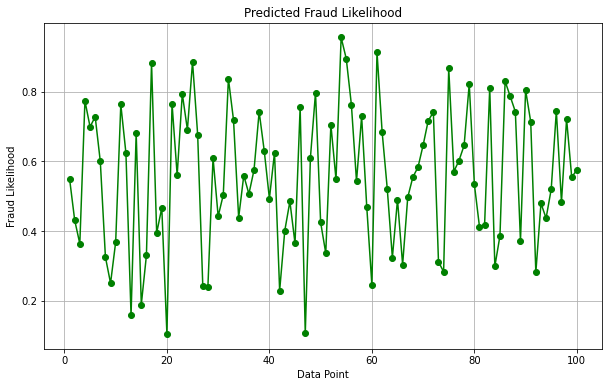

In [10]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

def get_fraud_chance_with_visualization(model_file, data):
    """
    This function takes a path to a trained machine learning model and an array of data,
    and it returns the model's estimates of the likelihood that each data point is fraudulent.
    It also visualizes these estimates.
    
    Arguments:
    - model_file: The location of the trained model on the disk.
    - data: Array of data points that the model will evaluate. This array should be formatted just like the data used to train the model.
    
    Outcome:
    - A visualization of each data point's estimated fraud likelihood according to the model.
    - An array with each data point's estimated fraud likelihood according to the model.
    """
    # Opening the model from the given file
    trained_model = load_model(model_file)
    
    # Making predictions with the model on the provided data
    fraud_chances = trained_model.predict(data).flatten()  # Ensuring it's a 1D array for easy plotting
    
    # Visualizing the fraud chances
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(fraud_chances) + 1), fraud_chances, marker='o', linestyle='-', color='green')
    plt.title('Predicted Fraud Likelihood')
    plt.xlabel('Data Point')
    plt.ylabel('Fraud Likelihood')
    plt.grid(True)
    plt.show()
    
    return fraud_chances

# Example usage:
# Assuming data_samples is defined as your input data array
predicted_fraud_chances = get_fraud_chance_with_visualization('model_saved.h5', data_samples)

# Note: You would replace 'model_saved.h5' with the actual path to your ANN model file,
# and ensure `data_samples` is prepared correctly for your model.


### Design and Training - CNN Model
This section introduces the steps for designing and training a Convolutional Neural Network (CNN) model specifically tailored for one-dimensional data, such as sequences or time-series data. CNNs are well-suited for recognizing patterns in spatial or temporal data thanks to their ability to capture local dependencies and scale input features effectively. 

In [11]:
from keras.models import Sequential, save_model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

def configure_cnn_model(input_length, num_features):
    """Configures a basic one-dimensional Convolutional Neural Network (CNN)."""
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(input_length, num_features)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_and_train_model(input_length=12, num_features=20, epochs=100, batch_size=32, test_split=0.2, sample_size=100):
    """
    Generates synthetic data and uses it to train the CNN model.
    This method streamlines the process of dataset creation and model training.
    """
    # Generating synthetic data
    features = np.random.rand(sample_size, input_length, num_features)
    labels = np.random.randint(2, size=(sample_size,))

    # Splitting the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=test_split, random_state=42)
    
    # Setting up the CNN model
    model = configure_cnn_model(input_length, num_features)
    
    # Training the model with the synthetic data
    training_summary = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)
    
    # Displaying training and validation results
    print(f"Final Training Loss: {training_summary.history['loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {training_summary.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Loss: {training_summary.history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy: {training_summary.history['val_accuracy'][-1]:.4f}")
    
    # Saving the trained model to a file
    model.save('cnn_model.h5')
    print("Model training complete and saved as cnn_model.h5.")

# Running the training process with predefined settings
prepare_and_train_model()


Epoch 1/100
3/3 [==============================] - 1s 62ms/step - loss: 0.7161 - accuracy: 0.5250 - val_loss: 0.6895 - val_accuracy: 0.5500
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 0.6889 - accuracy: 0.5875 - val_loss: 0.6884 - val_accuracy: 0.5000
Epoch 3/100
3/3 [==============================] - 0s 21ms/step - loss: 0.6780 - accuracy: 0.5500 - val_loss: 0.6931 - val_accuracy: 0.4500
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.6417 - accuracy: 0.6500 - val_loss: 0.7012 - val_accuracy: 0.4500
Epoch 5/100
3/3 [==============================] - 0s 27ms/step - loss: 0.6575 - accuracy: 0.5625 - val_loss: 0.7024 - val_accuracy: 0.4500
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6725 - accuracy: 0.4750 - val_loss: 0.7017 - val_accuracy: 0.4000
Epoch 7/100
3/3 [==============================] - 0s 25ms/step - loss: 0.6671 - accuracy: 0.6500 - val_loss: 0.7032 - val_accuracy: 0.5000
Epoch 8/100
3/3 [===

3/3 [==============================] - 0s 20ms/step - loss: 0.1071 - accuracy: 0.9875 - val_loss: 0.7094 - val_accuracy: 0.6500
Epoch 60/100
3/3 [==============================] - 0s 18ms/step - loss: 0.1156 - accuracy: 1.0000 - val_loss: 0.7057 - val_accuracy: 0.6000
Epoch 61/100
3/3 [==============================] - 0s 21ms/step - loss: 0.1254 - accuracy: 0.9875 - val_loss: 0.7505 - val_accuracy: 0.6500
Epoch 62/100
3/3 [==============================] - 0s 18ms/step - loss: 0.1167 - accuracy: 0.9875 - val_loss: 0.7326 - val_accuracy: 0.6500
Epoch 63/100
3/3 [==============================] - 0s 29ms/step - loss: 0.1059 - accuracy: 1.0000 - val_loss: 0.7120 - val_accuracy: 0.6000
Epoch 64/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0887 - accuracy: 1.0000 - val_loss: 0.7179 - val_accuracy: 0.6000
Epoch 65/100
3/3 [==============================] - 0s 18ms/step - loss: 0.1073 - accuracy: 0.9750 - val_loss: 0.7289 - val_accuracy: 0.6000
Epoch 66/100
3/3 [========

In [12]:
from keras.models import load_model
import numpy as np
import pandas as pd

def evaluate_fraud_risk(model_file, input_data):
    """
    This function opens a machine learning model that's been trained to identify fraud.
    It examines each data point provided to estimate its likelihood of being fraudulent.
    The results are organized into a table, making it easier to understand the model's assessments.
    
    Arguments:
    - model_file: The file location of the machine learning model.
    - input_data: Data for the model to evaluate, formatted as an array. This array must be prepared in the same way as the data used for training the model.
    
    Outcome:
    - A table (DataFrame) showing each data point with its calculated fraud risk.
    """
    # Opening the specified machine learning model
    trained_model = load_model(model_file)
    
    # Using the model to estimate fraud risk for the provided data
    estimated_risk = trained_model.predict(input_data).flatten()
    
    # Organizing the risk estimates into a table
    risk_table = pd.DataFrame({
        'Data Point': np.arange(1, len(estimated_risk) + 1), 
        'Estimated Fraud Risk': estimated_risk
    })
    
    # Sharing the organized table
    return risk_table

# For the purpose of demonstration, synthetic data resembling the model's training format is created
sample_size = 100  # Suppose there are 100 data points to evaluate
sequence_length = 12  # Each data point is a sequence of 12 steps
feature_count = 20  # Each step in the sequence has 20 features
simulated_data = np.random.rand(sample_size, sequence_length, feature_count)

# Predicting fraud risk with the provided model file and simulated data
fraud_risk_table = evaluate_fraud_risk('cnn_model.h5', simulated_data)
# Showing the first 40 data points and their estimated fraud risk for clarity
print(fraud_risk_table.tail(60))


4/4 [==============================] - 0s 2ms/step
    Data Point  Estimated Fraud Risk
40          41              0.915805
41          42              0.063838
42          43              0.080182
43          44              0.320194
44          45              0.640082
45          46              0.157346
46          47              0.908224
47          48              0.415974
48          49              0.877454
49          50              0.055808
50          51              0.650172
51          52              0.145962
52          53              0.772021
53          54              0.178035
54          55              0.990239
55          56              0.938443
56          57              0.767100
57          58              0.395669
58          59              0.950541
59          60              0.415411
60          61              0.019664
61          62              0.027391
62          63              0.081059
63          64              0.907992
64          65          

4/4 [==============================] - 0s 2ms/step


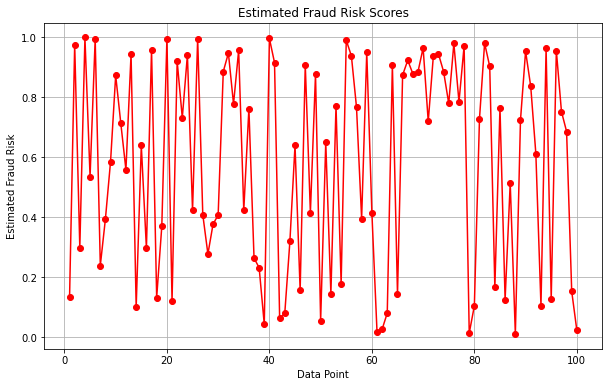

In [13]:
from keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_fraud_risk_with_visualization(model_file, input_data):
    """
    This function opens a machine learning model that's been trained to identify fraud.
    It examines each data point provided to estimate its likelihood of being fraudulent.
    The results are organized into a table and visualized, making it easier to understand the model's assessments.
    
    Arguments:
    - model_file: The file location of the machine learning model.
    - input_data: Data for the model to evaluate, formatted as an array. This array must be prepared in the same way as the data used for training the model.
    
    Outcome:
    - A table (DataFrame) showing each data point with its calculated fraud risk.
    - A visualization of the estimated fraud risk scores.
    """
    # Opening the specified machine learning model
    trained_model = load_model(model_file)
    
    # Using the model to estimate fraud risk for the provided data
    estimated_risk = trained_model.predict(input_data).flatten()
    
    # Organizing the risk estimates into a table
    risk_table = pd.DataFrame({
        'Data Point': np.arange(1, len(estimated_risk) + 1), 
        'Estimated Fraud Risk': estimated_risk
    })
    
    # Visualizing the risk scores
    plt.figure(figsize=(10, 6))
    plt.plot(risk_table['Data Point'].values, risk_table['Estimated Fraud Risk'].values, marker='o', linestyle='-', color='red')
    plt.title('Estimated Fraud Risk Scores')
    plt.xlabel('Data Point')
    plt.ylabel('Estimated Fraud Risk')
    plt.grid(True)
    plt.show()
    
    # Sharing the organized table
    return risk_table

# For the purpose of demonstration, synthetic data resembling the model's training format is created
# sample_size = 100  # Suppose there are 100 data points to evaluate
# sequence_length = 12  # Each data point is a sequence of 12 steps
# feature_count = 20  # Each step in the sequence has 20 features
# simulated_data = np.random.rand(sample_size, sequence_length, feature_count)

# Predicting fraud risk with the provided model file and simulated data
fraud_risk_table_with_viz = evaluate_fraud_risk_with_visualization('cnn_model.h5', simulated_data)
# Note: You would replace 'cnn_model.h5' with the actual path to your CNN model file,
# and ensure `simulated_data` is prepared correctly for your model.


### Design and Training - RNN Model
This section outlines the steps for designing and training a Recurrent Neural Network (RNN) model, focusing on Long Short-Term Memory (LSTM) layers. RNNs are particularly suited for sequential or time-series data due to their ability to retain information from previous inputs in the sequence. 

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np


In [15]:
def configure_rnn_model(input_length, num_features):
    """Configures a basic Recurrent Neural Network (RNN) using LSTM layers."""
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(input_length, num_features)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [16]:
def prepare_and_train_rnn_model(input_length=12, num_features=20, epochs=100, batch_size=32, test_split=0.2, sample_size=100):
    """
    Generates synthetic data and uses it to train the RNN model.
    """
    # Generating synthetic data
    features = np.random.rand(sample_size, input_length, num_features)
    labels = np.random.randint(2, size=(sample_size,))

    # Splitting the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=test_split, random_state=42)
    
    # Setting up the RNN model
    model = configure_rnn_model(input_length, num_features)
    
    # Training the model with the synthetic data
    training_summary = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)
    
    # Displaying training and validation results
    print(f"Final Training Loss: {training_summary.history['loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {training_summary.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Loss: {training_summary.history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy: {training_summary.history['val_accuracy'][-1]:.4f}")
    
    # Saving the trained model to a file
    model.save('rnn_model.h5')
    print("Model training complete and saved as rnn_model.h5.")

# You can now run the training process with:
prepare_and_train_rnn_model()


Epoch 1/100
3/3 [==============================] - 3s 300ms/step - loss: 0.6805 - accuracy: 0.5250 - val_loss: 0.6831 - val_accuracy: 0.6000
Epoch 2/100
3/3 [==============================] - 0s 33ms/step - loss: 0.6868 - accuracy: 0.5375 - val_loss: 0.6896 - val_accuracy: 0.6500
Epoch 3/100
3/3 [==============================] - 0s 35ms/step - loss: 0.7121 - accuracy: 0.4000 - val_loss: 0.6927 - val_accuracy: 0.4500
Epoch 4/100
3/3 [==============================] - 0s 33ms/step - loss: 0.6965 - accuracy: 0.5625 - val_loss: 0.6927 - val_accuracy: 0.4500
Epoch 5/100
3/3 [==============================] - 0s 32ms/step - loss: 0.6952 - accuracy: 0.4875 - val_loss: 0.6896 - val_accuracy: 0.6000
Epoch 6/100
3/3 [==============================] - 0s 39ms/step - loss: 0.6915 - accuracy: 0.4250 - val_loss: 0.6869 - val_accuracy: 0.7500
Epoch 7/100
3/3 [==============================] - 0s 33ms/step - loss: 0.6729 - accuracy: 0.7250 - val_loss: 0.6908 - val_accuracy: 0.4500
Epoch 8/100
3/3 [==

3/3 [==============================] - 0s 28ms/step - loss: 0.4632 - accuracy: 0.8250 - val_loss: 0.6938 - val_accuracy: 0.6500
Epoch 60/100
3/3 [==============================] - 0s 25ms/step - loss: 0.3993 - accuracy: 0.8375 - val_loss: 0.7088 - val_accuracy: 0.6500
Epoch 61/100
3/3 [==============================] - 0s 33ms/step - loss: 0.4039 - accuracy: 0.8500 - val_loss: 0.6698 - val_accuracy: 0.7000
Epoch 62/100
3/3 [==============================] - 0s 34ms/step - loss: 0.3742 - accuracy: 0.8500 - val_loss: 0.6567 - val_accuracy: 0.7500
Epoch 63/100
3/3 [==============================] - 0s 28ms/step - loss: 0.3917 - accuracy: 0.8375 - val_loss: 0.6828 - val_accuracy: 0.6500
Epoch 64/100
3/3 [==============================] - 0s 31ms/step - loss: 0.3696 - accuracy: 0.8750 - val_loss: 0.7143 - val_accuracy: 0.6500
Epoch 65/100
3/3 [==============================] - 0s 30ms/step - loss: 0.3550 - accuracy: 0.8500 - val_loss: 0.6735 - val_accuracy: 0.6500
Epoch 66/100
3/3 [========

In [17]:
from keras.models import load_model
import numpy as np
import pandas as pd

def evaluate_email_risk(model_file, input_data):
    """
    This function opens a machine learning model that's been trained to identify high-risk emails,
    such as potential spam or phishing attempts. It examines each data point provided to estimate
    its likelihood of being high-risk. The results are organized into a table, making it easier to
    understand the model's assessments.
    
    Arguments:
    - model_file: The file location of the machine learning model.
    - input_data: Data for the model to evaluate, formatted as an array. This array must be prepared
      in the same way as the data used for training the model.
    
    Outcome:
    - A table (DataFrame) showing each data point with its calculated risk score.
    """
    # Opening the specified machine learning model
    trained_model = load_model(model_file)
    
    # Using the model to estimate email risk for the provided data
    estimated_risk = trained_model.predict(input_data).flatten()
    
    # Organizing the risk estimates into a table
    risk_table = pd.DataFrame({
        'Data Point': np.arange(1, len(estimated_risk) + 1),
        'Estimated Risk Score': estimated_risk
    })
    
    # Sharing the organized table
    return risk_table

# Assuming `simulated_data` matches the RNN model's expected input format
# For demonstration purposes, creating synthetic data resembling the model's training format
sample_size = 100  # Suppose there are 100 data points to evaluate
sequence_length = 12  # Each data point is a sequence of 12 steps
feature_count = 20  # Each step in the sequence has 20 features
simulated_data = np.random.rand(sample_size, sequence_length, feature_count)

# Predicting email risk with the provided RNN model file and simulated data
email_risk_table = evaluate_email_risk('rnn_model.h5', simulated_data)

# Showing the last 60 data points and their estimated risk score for clarity
print(email_risk_table.tail(10))


4/4 [==============================] - 1s 5ms/step
    Data Point  Estimated Risk Score
90          91              0.125817
91          92              0.767575
92          93              0.196841
93          94              0.999337
94          95              0.999183
95          96              0.198503
96          97              0.198140
97          98              0.999561
98          99              0.127599
99         100              0.409280


4/4 [==============================] - 0s 4ms/step


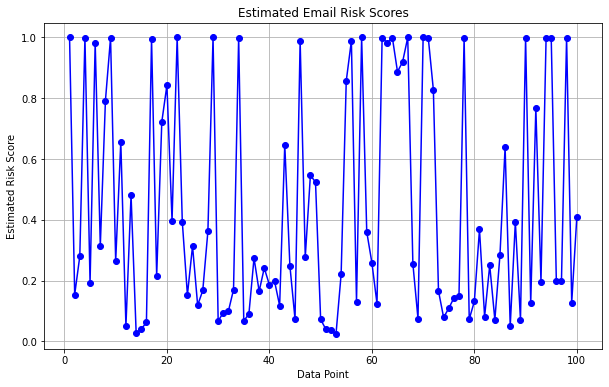

In [18]:
from keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_email_risk_with_visualization(model_file, input_data):
    """
    This function opens a machine learning model, uses it to estimate the risk of
    each provided data point being high-risk, and visualizes these estimates.
    
    Arguments:
    - model_file: The file location of the machine learning model.
    - input_data: Data for the model to evaluate, formatted as an array.
    
    Outcome:
    - A visualization of each data point's estimated risk score.
    """
    # Opening the specified machine learning model
    trained_model = load_model(model_file)
    
    # Using the model to estimate email risk for the provided data
    estimated_risk = trained_model.predict(input_data).flatten()
    
    # Organizing the risk estimates into a table
    risk_table = pd.DataFrame({
        'Data Point': np.arange(1, len(estimated_risk) + 1),
        'Estimated Risk Score': estimated_risk
    })
    
    # Visualizing the risk scores
    plt.figure(figsize=(10, 6))
    plt.plot(risk_table['Data Point'].values, risk_table['Estimated Risk Score'].values, marker='o', linestyle='-', color='blue')
    plt.title('Estimated Email Risk Scores')
    plt.xlabel('Data Point')
    plt.ylabel('Estimated Risk Score')
    plt.grid(True)
    plt.show()
    
    # Sharing the organized table
    return risk_table

# Example usage:
# Assuming `simulated_data` is already defined and matches the model's input format
email_risk_table_with_viz = evaluate_email_risk_with_visualization('rnn_model.h5', simulated_data)
# Note: You would replace 'rnn_model.h5' with the actual path to your RNN model file,
# and ensure `simulated_data` is prepared correctly for your model.


In [19]:
import numpy as np
import pandas as pd
from keras.models import load_model

def evaluate_and_filter_high_risk(model_file, input_data, risk_threshold=0.8):
    """
    This function loads a trained machine learning model, predicts the risk scores
    for the provided email data, and filters to only show high-risk scores above
    a certain threshold.
    
    Arguments:
    - model_file: The file path to the trained machine learning model.
    - input_data: The data on which to perform the risk assessment.
    - risk_threshold: The cutoff value above which a score is considered high risk.
    
    Returns:
    - A DataFrame containing only the high-risk scores and their corresponding data points.
    """
    # Load the trained machine learning model
    model = load_model(model_file)
    
    # Predict the risk scores using the model
    risk_scores = model.predict(input_data).flatten()
    
    # Create a DataFrame of the results
    risk_df = pd.DataFrame({
        'Data Point': np.arange(1, len(risk_scores) + 1),
        'Risk Score': risk_scores
    })
    
    # Filter the DataFrame to only include high-risk scores
    high_risk_df = risk_df[risk_df['Risk Score'] > risk_threshold]
    
    return high_risk_df

# Example usage:
# Assuming `simulated_data` is available and properly formatted
high_risk_emails = evaluate_and_filter_high_risk('rnn_model.h5', simulated_data)
print(high_risk_emails)


4/4 [==============================] - 0s 6ms/step
    Data Point  Risk Score
0            1    0.999877
3            4    0.999754
5            6    0.982787
8            9    0.999063
16          17    0.995471
19          20    0.842960
21          22    0.999899
28          29    0.999834
33          34    0.999004
45          46    0.989129
54          55    0.857071
55          56    0.988507
57          58    0.999839
61          62    0.999648
62          63    0.981683
63          64    0.999330
64          65    0.887088
65          66    0.919870
66          67    0.999875
69          70    0.999866
70          71    0.999687
71          72    0.827830
77          78    0.998655
89          90    0.999461
93          94    0.999337
94          95    0.999183
97          98    0.999561


In [20]:
import numpy as np
import pandas as pd
from keras.models import load_model

def retrieve_high_risk_emails(model_file, input_data, emails, data_points):
    """
    Retrieves high-risk emails based on the provided list of data points
    considered high risk.
    
    Arguments:
    - model_file: Path to the trained model.
    - input_data: Input data the model evaluates.
    - emails: List of email contents corresponding to each entry in input_data.
    - data_points: Indices of data points flagged as high risk.
    
    Returns:
    - DataFrame with data points, their risk scores, and email contents for high-risk emails.
    """
    model = load_model(model_file)
    risk_scores = model.predict(input_data).flatten()
    
    high_risk_emails = {
        'Data Point': [],
        'Risk Score': [],
        'Email Content': []
    }
    
    for i in data_points:
        if i-1 < len(risk_scores):
            high_risk_emails['Data Point'].append(i)
            high_risk_emails['Risk Score'].append(risk_scores[i-1])
            high_risk_emails['Email Content'].append(emails[i-1] if i-1 < len(emails) else "Email content not available")
    
    return pd.DataFrame(high_risk_emails)

# Assuming `simulated_data` is your model's input and `high_risk_data_points` contains indices of high-risk emails.
high_risk_data_points = [16, 39, 44, 50, 59, 86, 89]  # Adjust as per your findings
email_contents = ["Email content 1", "Email content 2", "..."]  # Fill with actual email contents

# Ensure `email_contents` has an entry for each item in `simulated_data`
high_risk_emails_df = retrieve_high_risk_emails('rnn_model.h5', simulated_data, email_contents, high_risk_data_points)
print(high_risk_emails_df)


4/4 [==============================] - 0s 7ms/step
   Data Point  Risk Score                Email Content
0          16    0.062216  Email content not available
1          39    0.241253  Email content not available
2          44    0.248917  Email content not available
3          50    0.072114  Email content not available
4          59    0.360039  Email content not available
5          86    0.639137  Email content not available
6          89    0.070467  Email content not available
